In [ ]:
# ==============
#  Standard 
# ==============
import os
import glob
import zipfile
import random
from pathlib import Path

# ============================
# Data Handling
# ============================
import numpy as np
import pandas as pd

# ============================
# Visualización
# ============================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Manejo de imágenes
# ============================
from PIL import Image, ImageOps, ImageFilter

# ============================
# PyTorch 
# ============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split

# ============================
# TorchVision
# ============================
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.transforms import RandAugment
import torchvision.transforms as transforms

# ============================
# TensorBoard
# ============================
from torch.utils.tensorboard import SummaryWriter

# ============================
# Métricas (sklearn)
# ============================
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    precision_recall_fscore_support,
    confusion_matrix
)

# ============================
# Jupyter Utilities
# ============================
from IPython.display import HTML, display



📁 Ruta de trabajo: C:/Users/ju4nm/Desktop/maestria_CDAA/ResNet_EuroSat


#### Descarga del Dataset EuroSAT_RGB de la plataforma Kaggle. En caso de usar **Google Colab**

In [ ]:
# # =====================================================
# # ✅ DESCARGAR DATASET DE KAGGLE EN GOOGLE COLAB
# # =====================================================

# 1. Montar Google Drive
#drive.mount('/content/drive')



# # 2️⃣ Definir ruta base de trabajo
# BASE_DIR = "C:/Users/ju4nm/Desktop/maestria_CDAA/trabajo_final_DL"
# os.makedirs(BASE_DIR, exist_ok=True)
# print("📁 Ruta de trabajo:", BASE_DIR)

# # 3️⃣ Instalar Kaggle CLI si no está
# !pip -q install kaggle

# # 4️⃣ Subir kaggle.json desde tu computadora local
# print("🔑 Subí tu kaggle.json (desde tu PC, se usa solo temporalmente)")
# uploaded = files.upload()
# uploaded_file = list(uploaded.values())[0]

# # 5️⃣ Configurar Kaggle CLI con permisos seguros
# os.makedirs("/root/.kaggle", exist_ok=True)
# with open("/root/.kaggle/kaggle.json", "wb") as f:
#     f.write(uploaded_file)
# os.chmod("/root/.kaggle/kaggle.json", 0o600)

# # 6️⃣ Descargar el dataset desde Kaggle
# DATASET_SLUG = "georgehanyfouad/eurosat-2-land-type-classification"
# !kaggle datasets download -d $DATASET_SLUG -p "$BASE_DIR"

# # 7️⃣ Extraer los archivos ZIP descargados
# for zpath in glob.glob(f"{BASE_DIR}/*.zip"):
#     print("🗜️  Extrayendo:", zpath)
#     with zipfile.ZipFile(zpath, "r") as zf:
#         zf.extractall(BASE_DIR)

# # 8️⃣ (Opcional) borrar los ZIPs para ahorrar espacio
# # for zpath in glob.glob(f"{BASE_DIR}/*.zip"):
# #     os.remove(zpath)

# # 9️⃣ Eliminar credencial de Kaggle por seguridad
# try:
#     os.remove("/root/.kaggle/kaggle.json")
#     print("🔒 Kaggle token eliminado del entorno.")
# except FileNotFoundError:
#     pass

# # 🔟 Mostrar contenido final de la carpeta
# print("\n✅ Contenido actual en:", BASE_DIR)
# for p in Path(BASE_DIR).glob("*"):
#     print(" -", p)


🗜️  Extrayendo: C:/Users/ju4nm/Desktop/maestria_CDAA/ResNet_EuroSat/archive.zip

✅ Contenido actual en: C:/Users/ju4nm/Desktop/maestria_CDAA/ResNet_EuroSat
 - C:\Users\ju4nm\Desktop\maestria_CDAA\ResNet_EuroSat\.git
 - C:\Users\ju4nm\Desktop\maestria_CDAA\ResNet_EuroSat\archive.zip
 - C:\Users\ju4nm\Desktop\maestria_CDAA\ResNet_EuroSat\environment.yml
 - C:\Users\ju4nm\Desktop\maestria_CDAA\ResNet_EuroSat\EuroSAT_RGB
 - C:\Users\ju4nm\Desktop\maestria_CDAA\ResNet_EuroSat\ResNet-50_EuroSat.ipynb


##### Definir rutas y extraer dataset del ZIP

In [5]:
# ====================================
# 📁 Configuración de rutas locales
# ====================================

# Ruta base del proyecto local
BASE_DIR = "C:/Users/ju4nm/Desktop/maestria_CDAA/ResNet_EuroSat"
os.makedirs(BASE_DIR, exist_ok=True)

print("📁 Ruta de trabajo:", BASE_DIR)

# Ruta al ZIP con el dataset dentro del repositorio
ZIP_PATH = Path(BASE_DIR) / "archive.zip"

# Carpeta donde se extraerá el dataset
DATASET_EXTRACT_DIR = Path(BASE_DIR) / "EuroSAT_RGB"

# ====================================
# 🗜️ Extraer dataset si no existe
# ====================================

if not DATASET_EXTRACT_DIR.exists():
    print("🗜️ Extrayendo dataset desde:", ZIP_PATH)
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(BASE_DIR)
    print("✅ Dataset extraído en:", DATASET_EXTRACT_DIR)
else:
    print("✅ Dataset ya existe, no se vuelve a extraer.")


📁 Ruta de trabajo: C:/Users/ju4nm/Desktop/maestria_CDAA/ResNet_EuroSat
🗜️ Extrayendo dataset desde: C:\Users\ju4nm\Desktop\maestria_CDAA\ResNet_EuroSat\archive.zip
✅ Dataset extraído en: C:\Users\ju4nm\Desktop\maestria_CDAA\ResNet_EuroSat\EuroSAT_RGB


#### Verificación del contenido del dataset

In [6]:
# ====================================
# Verificación de clases del dataset
# ====================================

DATASET_DIR = BASE_DIR + "/EuroSAT_RGB"
print("📁 DATASET_DIR =", DATASET_DIR)

#Verificar que el directorio del dataset existe
if not os.path.exists(DATASET_DIR):
    raise ValueError(f"❌ ERROR: La carpeta {DATASET_DIR} no existe. Verificar descarga o ruta.")
else:
    print("✅ La carpeta del dataset existe.")


# Clases esperadas del dataset EuroSAT RGB
clases_esperadas = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

print("\nClases esperadas:")
print(clases_esperadas)

#Obtener carpetas reales en el dataset
clases= sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])

print("\nClases encontradas en el dataset:")
print(clases)

#Comparar listas
print("\nVerificación:")

if sorted(clases_esperadas) == sorted(clases):
    print("✅ Las clases coinciden exactamente con las esperadas.")
else:
    print("⚠️ Las clases NO coinciden con las esperadas.")

    faltantes = set(clases_esperadas) - set(clases)
    extras = set(clases) - set(clases_esperadas)

    if faltantes:
        print("   ❌ Faltan estas carpetas:", list(faltantes))
    if extras:
        print("   ❌ Carpetas inesperadas encontradas:", list(extras))


📁 DATASET_DIR = C:/Users/ju4nm/Desktop/maestria_CDAA/ResNet_EuroSat/EuroSAT_RGB
✅ La carpeta del dataset existe.

Clases esperadas:
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

Clases encontradas en el dataset:
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

Verificación:
✅ Las clases coinciden exactamente con las esperadas.


In [171]:
# ====================================
# Verificación extensiones por clase
# ===================================

import os
from collections import Counter
from pathlib import Path

# 1) Extensiones válidas permitidas
extensiones_validas = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"}

print("\n📌 Verificando extensiones por clase...\n")

# 2) Iterar sobre cada clase real del dataset
for clase in clases:

    carpeta = Path(DATASET_DIR) / clase

    # Usamos Counter para acumular extensiones rápidamente
    contador_ext = Counter()

    # Iteramos con os.scandir(), mucho más eficiente que listdir
    for entry in os.scandir(carpeta):
        if entry.is_file():
            ext = Path(entry.name).suffix.lower()
            contador_ext[ext] += 1

    # Total de imágenes
    total_imagenes = sum(contador_ext.values())

    print(f"🟦 Clase: {clase}")
    print(f"   Total de imágenes: {total_imagenes}")

    # 3) Mostrar conteo por extensión
    for ext, count in contador_ext.items():
        print(f"   {ext}: {count}")

    # 4) Detectar extensiones no válidas
    extensiones_invalidas = [ext for ext in contador_ext if ext not in extensiones_validas]

    if extensiones_invalidas:
        print(f"   ⚠️ Extensiones NO válidas encontradas: {extensiones_invalidas}")
    else:
        print("   ✔️ Todas las extensiones son válidas.")

    print("-" * 50)



📌 Verificando extensiones por clase...

🟦 Clase: AnnualCrop
   Total de imágenes: 3000
   .jpg: 3000
   ✔️ Todas las extensiones son válidas.
--------------------------------------------------
🟦 Clase: Forest
   Total de imágenes: 3000
   .jpg: 3000
   ✔️ Todas las extensiones son válidas.
--------------------------------------------------
🟦 Clase: HerbaceousVegetation
   Total de imágenes: 3000
   .jpg: 3000
   ✔️ Todas las extensiones son válidas.
--------------------------------------------------
🟦 Clase: Highway
   Total de imágenes: 2500
   .jpg: 2500
   ✔️ Todas las extensiones son válidas.
--------------------------------------------------
🟦 Clase: Industrial
   Total de imágenes: 2500
   .jpg: 2500
   ✔️ Todas las extensiones son válidas.
--------------------------------------------------
🟦 Clase: Pasture
   Total de imágenes: 2000
   .jpg: 2000
   ✔️ Todas las extensiones son válidas.
--------------------------------------------------
🟦 Clase: PermanentCrop
   Total de imágen


🖼️ Mostrando una imagen aleatoria por clase...



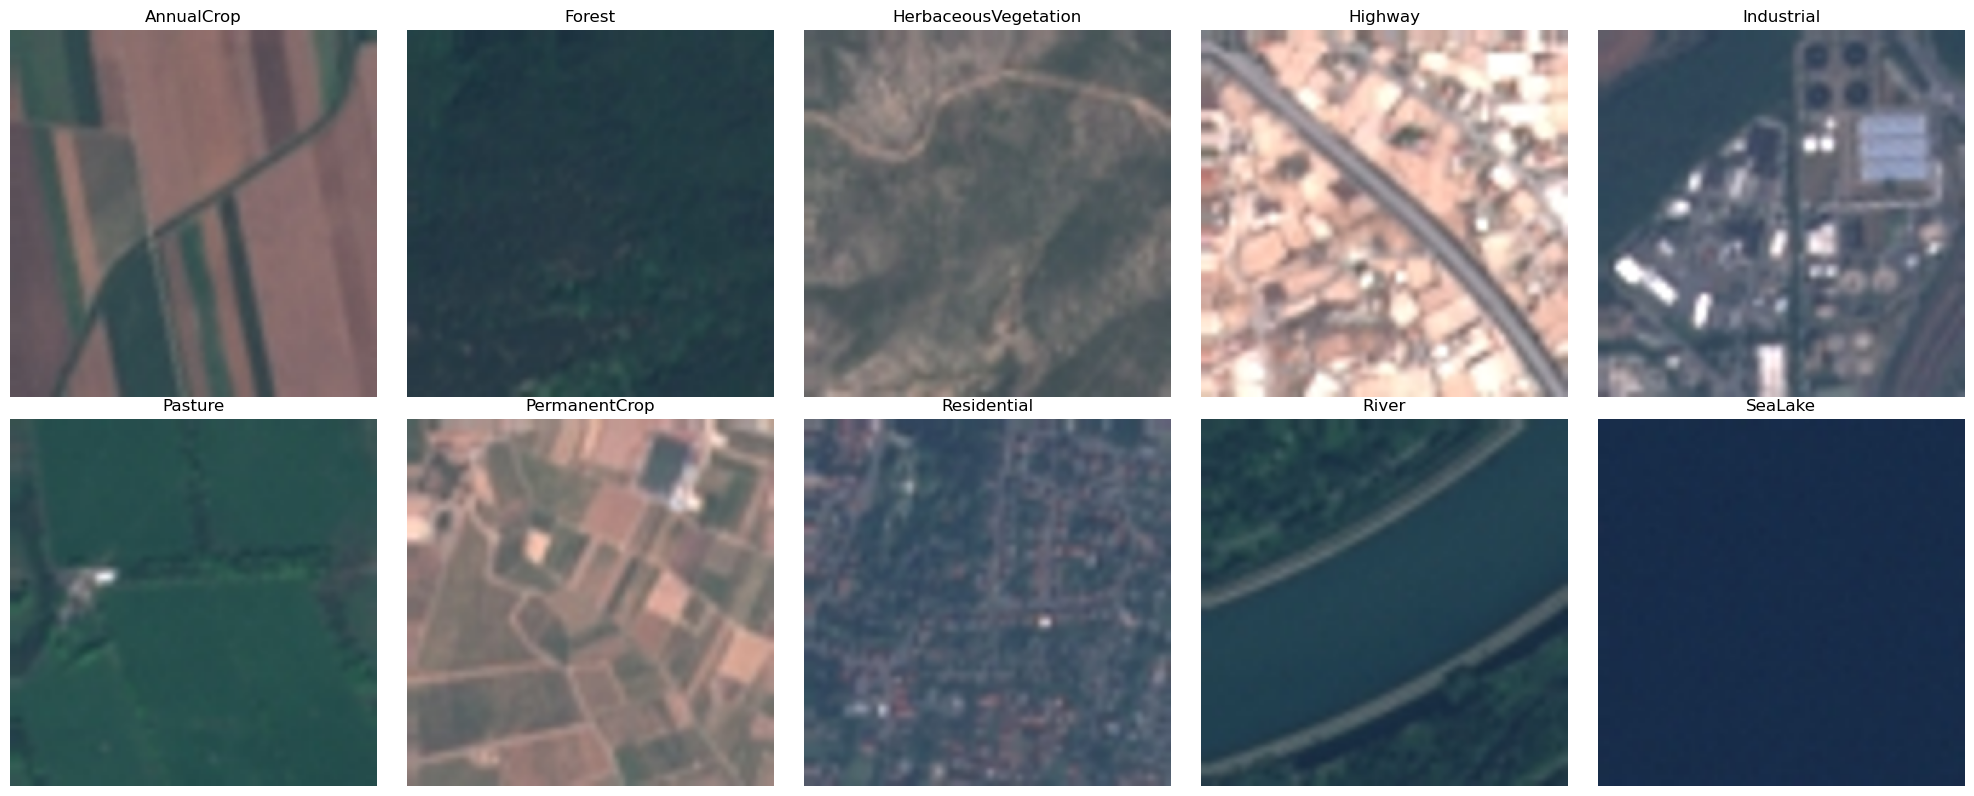

In [172]:
# =========================================
# Visualizar 1 imagen aleatoria por clase
# =========================================

print("\n🖼️ Mostrando una imagen aleatoria por clase...\n")

# Parámetro: tamaño de visualización (solo para mostrar)
VIS_SIZE = (224, 224)

num_clases = len(clases)

plt.figure(figsize=(20, 8))  # figura grande y clara

for idx, clase in enumerate(clases):

    carpeta_clase = Path(DATASET_DIR) / clase

    # Filtrar solo archivos válidos
    archivos = [
        f for f in os.listdir(carpeta_clase)
        if Path(f).suffix.lower() in extensiones_validas
    ]

    # Elegir una imagen aleatoria
    imagen_path = carpeta_clase / random.choice(archivos)

    # Abrir la imagen y hacer resize SOLO para mostrar
    imagen = Image.open(imagen_path).resize(VIS_SIZE)

    # Posición en grid: 2 filas, 5 columnas
    plt.subplot(2, 5, idx + 1)
    plt.imshow(imagen)
    plt.title(clase)
    plt.axis("off")

plt.tight_layout()
plt.show()


## ResNet-50(Baseline)

##### Transformaciones: Normalización y augmentation diferenciados(suaves y fuertes)

## Normalización y estadísticos de ImageNet

Dado que ResNet-50 fue preentrenada en **ImageNet**, utilizamos sus valores de media y desvío estándar:

- `mean = [0.485, 0.456, 0.406]`
- `std  = [0.229, 0.224, 0.225]`

Esto garantiza que las imágenes ingresen al modelo en el **mismo espacio estadístico** que durante su entrenamiento original, evitando desajustes en las primeras capas y asegurando un **transfer learning estable**.

Aunque podríamos calcular estadísticas propias del dataset EuroSAT, en la práctica **mantener las de ImageNet funciona mejor** para modelos preentrenados.


<!-- ##### Transformaciones: Normalización y augmentation diferenciados

**Se van entrenar dos Baselines, con todo el backbone congelado (exceptuando fc del final) uno sin augmentacions o tranforms suaves y otro con transformaciones más fuertes** -->

In [173]:
# ------------------------------------------------------------
# • Normalización estándar para ResNet-50 preentrenada
# ------------------------------------------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)

#### Transforms centralizados para los tres modelos

🟦 TRAIN SUAVE: baseline suave

Este modo aplica augmentations leves pensados para introducir variabilidad controlada sin alterar significativamente la estructura espacial de las imágenes. El objetivo es mejorar la capacidad de generalización del modelo baseline manteniendo una transformación moderada y estable del contenido visual. Es adecuado como punto de partida porque combina estabilidad con una robusta regularización básica.

🟧 TRAIN FUERTE: baseline fuerte y fine-tuning

Este modo utiliza augmentations más intensos para incrementar la diversidad visual del dataset y hacer al modelo más robusto frente a variaciones de escala, orientación, color e iluminación. Se aplica tanto al baseline fuerte como al modelo de fine-tuning, ya que ambos buscan un aprendizaje más profundo y resistente, reduciendo la dependencia de patrones simples o regiones específicas de la imagen.

🟩 VALIDACIÓN / TEST

En validación y test no usamos transformaciones aleatorias. A diferencia del entrenamiento ,donde las imágenes pueden cambiar en cada pasada por los augmentations(Resize, ToTensor y Normalize),aquí siempre aplicamos las mismas transformaciones fijas.

Esto garantiza que la evaluación sea estable y que podamos comparar los modelos de forma justa.

**Transformaciones utilizadas**

Normalize (**ImageNet**): coherencia con el backbone preentrenado.

Resize → RandomResizedCrop: invariancia a escala y composición. Como también **adaptación a la entrada de ResNet-50**.

RandomHorizontalFlip + RandomVerticalFlip: simetrías espaciales frecuentes en imágenes satelitales.

RandAugment: rota, desplaza, posteriza, solariza, etc. generando escenarios difíciles donde las texturas no son únicas.

ColorJitter fuerte: útil en escenas con variación ambiental (vegetación, iluminación, sombras).

RandomErasing: obliga al modelo a no depender de una sola región discriminativa.

In [174]:
# ============================================================
# TRANSFORMS CENTRALES (TRAIN SUAVE / TRAIN FUERTE / VAL-TEST)
# ============================================================

# ------------------------------------------------------------
#  TRAIN SUAVE — baseline original (augmentations leves)
# ------------------------------------------------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2
    ),
    transforms.ToTensor(),
    normalize
])

# ------------------------------------------------------------
# TRAIN FUERTE — baseline-fuerte + fine-tuning
# ------------------------------------------------------------
train_transform_strong = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    RandAugment(num_ops=2, magnitude=10),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.2),
    transforms.ToTensor(),
    normalize,
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
])

# ------------------------------------------------------------
# VALIDATION / TEST (para TODOS los modelos)
# ------------------------------------------------------------
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

print("Transforms definidos correctamente.")


Transforms definidos correctamente.


#### Creación de Dataloaders: Train,validation y test, con semilla para reproducibilidad

`random_split` no crea datasets nuevos, sino subconjuntos que comparten el mismo `ImageFolder` base y se diferencian solo por sus índices.  
 Por eso asignamos los transforms a `train_dataset.dataset.transform`, `val_dataset.dataset.transform`, etc.


In [175]:

# Ruta al dataset original con las carpetas de clases
DATASET_DIR = BASE_DIR + "/EuroSAT_RGB"

# Batch size recomendado para ResNet-50
BATCH_SIZE = 32


# ===================================================
# Crear dataset completo y dividir en train/val/test
# ===================================================

# Dataset sin transforms (solo para contar)
dataset_total = ImageFolder(DATASET_DIR)
class_names = dataset_total.classes



num_total = len(dataset_total)
num_train = int(0.7 * num_total)
num_val   = int(0.15 * num_total)
num_test  = num_total - num_train - num_val

print(f"Total: {num_total} | Train: {num_train} | Val: {num_val} | Test: {num_test}")


# División aleatoria
train_dataset, val_dataset, test_dataset = random_split(
    dataset_total,
    [num_train, num_val, num_test],
    generator=torch.Generator().manual_seed(42)    #REPRODUCIBILIAD
)


Total: 27000 | Train: 18900 | Val: 4050 | Test: 4050


In [176]:
# ==========================================
#  ASIGNAR TRANSFORMS (TRAIN / VAL / TEST)
# ==========================================

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform   = val_test_transforms
test_dataset.dataset.transform  = val_test_transforms

# ======================================
#  DATALOADERS SUAVES (baseline suave)
# ======================================

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print("🟢 DataLoaders suaves creados correctamente.")

# =============================================
# DATASET TRAIN FUERTE (baseline fuerte + FT)
# =============================================

dataset_train_strong = ImageFolder(
    DATASET_DIR,
    transform=train_transform_strong
)

train_dataset_strong = Subset(dataset_train_strong, train_dataset.indices)

train_loader_strong = DataLoader(
    train_dataset_strong,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("🟣 DataLoader fuerte creado correctamente.")

# =============================================================================
# DATASET TEST CON PATHS(para poner las imagenes con labels True y Predicted)
# =============================================================================

class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        path = self.samples[index][0]
        return img, label, path

# Dataset con paths para el test
test_dataset_paths = ImageFolderWithPaths(DATASET_DIR)

# FORZAR que use el mismo mapeo de clases que el dataset original
test_dataset_paths.classes = dataset_total.classes
test_dataset_paths.class_to_idx = dataset_total.class_to_idx

# transform antes del subset
test_dataset_paths.transform = val_test_transforms

# mismo split del test original
test_dataset_paths = Subset(test_dataset_paths, test_dataset.indices)

# loader que devuelve (img, label, path)
test_loader_paths = DataLoader(
    test_dataset_paths,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("📷 DataLoader de test con paths creado correctamente.")


🟢 DataLoaders suaves creados correctamente.
🟣 DataLoader fuerte creado correctamente.
📷 DataLoader de test con paths creado correctamente.


#### ResNet-50 preentrenada con el dataset ImageNet 
**Congelando del backbone, excepto la capa final fully connected**


In [177]:
# ============================================================
# Cargar ResNet-50 con pesos de ImageNet 
# Aplicar FREEZING total (solo entrenamos la capa final)
# ============================================================

def build_resnet50(num_classes=10, freeze=True):
    """
    Construye una ResNet-50 para clasificación de 10 clases.

    Parámetros:
    - num_classes: cantidad de clases del dataset (EuroSAT = 10)
    - freeze: si True, congela todo el backbone y solo entrena la capa final.
    """

    # 1) Cargar modelo preentrenado en ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    # 2) Congelar parámetros si freeze=True
    if freeze:
        for param in model.parameters():
            param.requires_grad = False

    # 3) Obtener tamaño de la capa final original (fc)
    in_features = model.fc.in_features   # 2048 en ResNet-50

    # 4) Reemplazar la clasificación original (1000 clases) por una para 10 clases
    model.fc = nn.Linear(in_features, num_classes)

    # Nota: la nueva capa "fc" NO está congelada aunque freeze=True,
    # porque acabamos de crearla y sus parámetros requieren grad por defecto.

    return model


# Crear el modelo
model = build_resnet50(num_classes=10, freeze=True)

# Verificación rápida
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##### Tensorboard SummaryWriter

In [178]:
# ============================================================
# Inicializar SummaryWriter (3 modelos) dentro de BASE_DIR
# ============================================================

# Asegurar carpeta "runs" dentro de BASE_DIR
runs_dir = os.path.join(BASE_DIR, "runs")
os.makedirs(runs_dir, exist_ok=True)

# Writers con nombres consistentes con los experimentos
writer_baseline_light_aug = SummaryWriter(
    log_dir=os.path.join(runs_dir, "baseline_light_aug")
)

writer_baseline_strong_aug = SummaryWriter(
    log_dir=os.path.join(runs_dir, "baseline_strong_aug")
)

writer_finetune_strong_aug = SummaryWriter(
    log_dir=os.path.join(runs_dir, "finetune_strong_aug")
)

print("TensorBoard Writers inicializados:")
print(" - baseline_light_aug   ->", os.path.join(runs_dir, "baseline_light_aug"))
print(" - baseline_strong_aug  ->", os.path.join(runs_dir, "baseline_strong_aug"))
print(" - finetune_strong_aug  ->", os.path.join(runs_dir, "finetune_strong_aug"))


TensorBoard Writers inicializados:
 - baseline_light_aug   -> C:/Users/ju4nm/Desktop/maestria_CDAA/trabajo_final_DL\runs\baseline_light_aug
 - baseline_strong_aug  -> C:/Users/ju4nm/Desktop/maestria_CDAA/trabajo_final_DL\runs\baseline_strong_aug
 - finetune_strong_aug  -> C:/Users/ju4nm/Desktop/maestria_CDAA/trabajo_final_DL\runs\finetune_strong_aug


#### Definición de las funciones: train_one_epoch() y validate_one_epoch()
- train_one_epoch() entrena el modelo durante una epoch completa, calcula gradientes y actualiza parametros entre otras actividades.
- validate_one_epoch() evalúa calculando loss y accuracy

In [179]:
# ==============================
# Entrenamiento para una epoch
# ==============================

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Entrena el modelo durante una epoch completa.
    Retorna: loss promedio y accuracy de entrenamiento.

Toma batches del training set.

Hace:

- forward

- calcula el loss

- loss.backward() → calcula gradientes

- optimizer.step() → actualiza parámetros

- Está en modo model.train()

- activa dropout

- activa batchnorm en modo actualización
    """
    model.train()   # modo entrenamiento
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()          # limpiar gradientes previos
        outputs = model(images)        # forward
        loss = criterion(outputs, labels)
        loss.backward()                # backward
        optimizer.step()               # actualizar parámetros (solo fc)

        # Acumular métricas
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


In [180]:
# ==========================
# Validación para una epoch
# ==========================

def validate_one_epoch(model, dataloader, criterion, device):
    """
    Evalúa el modelo sin actualizar parámetros.
    Retorna: loss promedio y accuracy de validación.

Toma batches del validation set.

Hace:

- forward

- calcula loss

- calcula accuracy

- NO hace backward

- NO actualiza parámetros

Está dentro de torch.no_grad(): → No se calculan gradientes
                                → El modelo solo se evalúa, no aprende

    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():   # imprescindible: evita gradientes
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


##### Definición de la función para entrenar el modelo

In [181]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    writer,
    epochs,
    device,
    patience,
    best_model_path=None,
):
    """
    Entrena y valida el modelo durante varias epochs.
    Early Stopping basado en val_loss.
    Guarda opcionalmente el mejor modelo (best_model_path).
    Registro en TensorBoard si writer != None.
    Retorna un diccionario con historial.
    """

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    model.to(device)

    best_val_loss = float("inf")
    best_state_dict = None
    epochs_without_improvement = 0

    import time

    for epoch in range(epochs):

        start_time = time.time()

        # --- Entrenamiento ---
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # --- Validación ---
        val_loss, val_acc = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # --- Scheduler ---
        if scheduler is not None:
            try:
                scheduler.step(val_loss)  # ReduceLROnPlateau
            except TypeError:
                scheduler.step()           # CosineAnnealing, StepLR, etc.

        # --- Guardar historial ---
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # --- TensorBoard (opcional) ---
        if writer is not None:
            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("Acc/train", train_acc, epoch)
            writer.add_scalar("Acc/val", val_acc, epoch)
            # Registrar Learning Rate 
            current_lr = optimizer.param_groups[0]["lr"]
            writer.add_scalar("LR", current_lr, epoch)

        # --- Tiempo ---
        elapsed = time.time() - start_time

        # ============================
        #   PRINT COMPACTO POR EPOCH
        # ============================
        print(
            f"📘 Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
            f"⏱️ {elapsed:.1f}s"
        )

        # ============================
        #       EARLY STOPPING
        # ============================
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            epochs_without_improvement = 0

            if best_model_path is not None:
                torch.save(best_state_dict, best_model_path)
                print(f"  💾 Mejor modelo guardado en: {best_model_path}")

        else:
            epochs_without_improvement += 1
            print(f"  ⏸️ Sin mejora por {epochs_without_improvement} epoch(s)")

            if epochs_without_improvement >= patience:
                print(f"\n⛔ Early stopping activado (patience = {patience})")
                break

    # =========================================
    # Restaurar el mejor modelo en memoria
    # =========================================
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        print("✅ Modelo restaurado al mejor estado (menor val_loss).")

    return history


##### Entreno ResNet-50 baseline(test) LR= 1e-3

In [182]:
# ==============================
# Definir la función de pérdida
# ==============================

# Para clasificación multiclase, CrossEntropyLoss es el estándar.
criterion = nn.CrossEntropyLoss()

print("Función de pérdida definida correctamente (CrossEntropyLoss).")

# Entrenamos ÚNICAMENTE model.fc porque el resto del backbone está congelado.
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

print("Optimizador definido correctamente (Adam sobre la capa final).")


# ============================================================
# Scheduler para ajustar el learning rate automáticamente
# ============================================================

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

print(f"Learning rate actualizado: {optimizer.param_groups[0]['lr']}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)



Función de pérdida definida correctamente (CrossEntropyLoss).
Optimizador definido correctamente (Adam sobre la capa final).
Learning rate actualizado: 0.001
Usando dispositivo: cuda


In [183]:
# # ===========================
# # Ejecutar el entrenamiento
# # ==========================


# # =====================================
# # Definición EPOCHS de los tres modelos
# # ====================================

# EPOCHS = 8   

# # ====================================

# history = train_model(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     criterion=criterion,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     writer=writer_baseline_light_aug,
#     epochs=EPOCHS,
#     device=device,
#     patience=2,                        
#     best_model_path="best_baseline.pth"  
# )



##### Definición de la función para testear modelos

In [184]:


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    y_true = []
    y_pred = []
    y_prob = []
    paths   = []

    with torch.no_grad():
        for images, labels, batch_paths in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            y_prob.extend(torch.softmax(outputs, dim=1).cpu().tolist())
            paths.extend(batch_paths)

    test_loss = running_loss / len(dataloader.dataset)
    test_acc  = accuracy_score(y_true, y_pred)

    return test_loss, test_acc, y_true, y_pred, y_prob, paths


In [185]:
# baseline_soft_eval = evaluate_model(
#     model,              # baseline suave
#     test_loader_paths,        # test limpio
#     criterion,
#     device
# )

# # Desempaquetar
# (bl_soft_loss,
#  bl_soft_acc,
#  bl_soft_y_true,
#  bl_soft_y_pred,
#  bl_soft_y_prob,
#  bl_soft_paths) = baseline_soft_eval

# print(f"Baseline Suave — Test Accuracy: {bl_soft_acc:.4f}")


##### Entreno ResNet-50 baseline LR= 5e-4

In [186]:

# =====================================
# Definición EPOCHS de los tres modelos
# ====================================

EPOCHS = 8   

# ====================================
optimizer = optim.Adam(model.fc.parameters(), lr=5e-4)


history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    writer=writer_baseline_light_aug,
    epochs=EPOCHS,
    device=device,
    patience=2,                        
    best_model_path="best_baseline.pth"  
)



📘 Epoch 1/8 | Train Loss: 0.8358, Acc: 0.7838 | Val Loss: 0.4438, Acc: 0.8837 | ⏱️ 106.1s
  💾 Mejor modelo guardado en: best_baseline.pth
📘 Epoch 2/8 | Train Loss: 0.4391, Acc: 0.8701 | Val Loss: 0.3337, Acc: 0.9062 | ⏱️ 105.1s
  💾 Mejor modelo guardado en: best_baseline.pth
📘 Epoch 3/8 | Train Loss: 0.3599, Acc: 0.8919 | Val Loss: 0.2846, Acc: 0.9178 | ⏱️ 105.9s
  💾 Mejor modelo guardado en: best_baseline.pth
📘 Epoch 4/8 | Train Loss: 0.3086, Acc: 0.9056 | Val Loss: 0.2486, Acc: 0.9252 | ⏱️ 108.4s
  💾 Mejor modelo guardado en: best_baseline.pth
📘 Epoch 5/8 | Train Loss: 0.2759, Acc: 0.9151 | Val Loss: 0.2343, Acc: 0.9291 | ⏱️ 108.7s
  💾 Mejor modelo guardado en: best_baseline.pth
📘 Epoch 6/8 | Train Loss: 0.2560, Acc: 0.9204 | Val Loss: 0.2284, Acc: 0.9274 | ⏱️ 108.6s
  💾 Mejor modelo guardado en: best_baseline.pth
📘 Epoch 7/8 | Train Loss: 0.2393, Acc: 0.9256 | Val Loss: 0.2103, Acc: 0.9299 | ⏱️ 108.0s
  💾 Mejor modelo guardado en: best_baseline.pth
📘 Epoch 8/8 | Train Loss: 0.2264, 

In [187]:
baseline_soft_eval = evaluate_model(
    model,              # baseline suave
    test_loader_paths,        
    criterion,
    device
)

# Desempaquetar
(bl_soft_loss,
 bl_soft_acc,
 bl_soft_y_true,
 bl_soft_y_pred,
 bl_soft_y_prob,
 bl_soft_paths) = baseline_soft_eval

print(f"Baseline Suave — Test Accuracy: {bl_soft_acc:.4f}")


Baseline Suave — Test Accuracy: 0.9360


#### ResNet-50 Baseline fuerte (Augmentations en train) **Entrenamiento y evaluación**

In [188]:
# ============================================================
# Segundo modelo BASELINE (con augmentations fuertes)
# Backbone completamente congelado
# ============================================================

model_strong = build_resnet50(num_classes=10, freeze=True)
print(model_strong)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##### Con LR 1e-3

In [189]:
# # OPTIMIZER (idéntico al baseline suave, pero variable independiente)
# optimizer_strong = optim.Adam(model_strong.fc.parameters(), lr=1e-3)

# # SCHEDULER (idéntico y separado)
# scheduler_strong = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer_strong,
#     mode='min',
#     factor=0.5,
#     patience=2
# )



# history_base_strong = train_model(
#     model=model_strong,
#     train_loader=train_loader_strong,   
#     val_loader=val_loader,
#     criterion=criterion,
#     optimizer=optimizer_strong,
#     scheduler=scheduler_strong,
#     writer=writer_baseline_strong_aug,                        
#     epochs=EPOCHS,
#     device=device,
#     patience=3,
#     best_model_path="best_resnet50_baseline_strong.pth"
# )


In [190]:
# baseline_strong_eval = evaluate_model(
#     model_strong,       # baseline con strong augmentation en training
#     test_loader_paths,        # test limpio
#     criterion,
#     device
# )

# (bl_strong_loss,
#  bl_strong_acc,
#  bl_strong_true,
#  bl_strong_pred,
#  bl_strong_prob,
#  bl_strong_paths) = baseline_strong_eval

# print(f"Baseline Fuerte — Test Accuracy: {bl_strong_acc:.4f}")


##### Con LR 5e-4

In [191]:
# OPTIMIZER (idéntico al baseline suave, pero variable independiente)
optimizer_strong = optim.Adam(model_strong.fc.parameters(), lr=5e-4)

# SCHEDULER (idéntico y separado)
scheduler_strong = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_strong,
    mode='min',
    factor=0.5,
    patience=2
)



history_base_strong = train_model(
    model=model_strong,
    train_loader=train_loader_strong,   
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_strong,
    scheduler=scheduler_strong,
    writer=writer_baseline_strong_aug,                        
    epochs=EPOCHS,
    device=device,
    patience=2,
    best_model_path="best_resnet50_baseline_strong.pth"
)


📘 Epoch 1/8 | Train Loss: 1.2038, Acc: 0.6525 | Val Loss: 0.8607, Acc: 0.7733 | ⏱️ 213.7s
  💾 Mejor modelo guardado en: best_resnet50_baseline_strong.pth
📘 Epoch 2/8 | Train Loss: 0.7884, Acc: 0.7583 | Val Loss: 0.6916, Acc: 0.7975 | ⏱️ 212.4s
  💾 Mejor modelo guardado en: best_resnet50_baseline_strong.pth
📘 Epoch 3/8 | Train Loss: 0.6878, Acc: 0.7801 | Val Loss: 0.6297, Acc: 0.8173 | ⏱️ 212.9s
  💾 Mejor modelo guardado en: best_resnet50_baseline_strong.pth
📘 Epoch 4/8 | Train Loss: 0.6360, Acc: 0.7968 | Val Loss: 0.5558, Acc: 0.8358 | ⏱️ 213.0s
  💾 Mejor modelo guardado en: best_resnet50_baseline_strong.pth
📘 Epoch 5/8 | Train Loss: 0.5925, Acc: 0.8107 | Val Loss: 0.5241, Acc: 0.8390 | ⏱️ 212.6s
  💾 Mejor modelo guardado en: best_resnet50_baseline_strong.pth
📘 Epoch 6/8 | Train Loss: 0.5708, Acc: 0.8143 | Val Loss: 0.5499, Acc: 0.8284 | ⏱️ 212.3s
  ⏸️ Sin mejora por 1 epoch(s)
📘 Epoch 7/8 | Train Loss: 0.5508, Acc: 0.8187 | Val Loss: 0.4821, Acc: 0.8519 | ⏱️ 208.4s
  💾 Mejor modelo gu

In [192]:
baseline_strong_eval = evaluate_model(
    model_strong,       # baseline con strong augmentation en training
    test_loader_paths,        # test limpio
    criterion,
    device
)

(bl_strong_loss,
 bl_strong_acc,
 bl_strong_true,
 bl_strong_pred,
 bl_strong_prob,
 bl_strong_paths) = baseline_strong_eval

print(f"Baseline Fuerte — Test Accuracy: {bl_strong_acc:.4f}")


Baseline Fuerte — Test Accuracy: 0.8551


## ResNet-50 finetuning


- Reemplazar la capa final (fc) por una de 10 clases (EuroSAT)
- **Backbone casi congelado:** mantenemos congeladas todas las capas excepto `layer4`, el bloque más profundo. Así aprovechamos las features generales aprendidas en ImageNet y solo ajustamos las características **más abstractas**.
- **Parámetros entrenables controlados:** revisamos cuántos parámetros totales y cuántos quedan con `requires_grad=True` para asegurarnos de que solo se actualicen `layer4` y la capa final durante el entrenamiento.

In [193]:
import torch
import torch.nn as nn
from torchvision import models

# Cargar ResNet-50 preentrenada
resnet50_finetunning = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# ------------------------------
#  Congelar el backbone
# ------------------------------
for param in resnet50_finetunning.parameters():
    param.requires_grad = False

# ------------------------------------------------
# Descongelar SOLO layer4 (bloque más profundo)
# ------------------------------------------------
# Esto permite que la red ajuste features específicas
# de las clases difíciles (Highway, Pasture, River, etc.)
for param in resnet50_finetunning.layer4.parameters():
    param.requires_grad = True

# ----------------------------------
# Reemplazar la Fully Connected
# ----------------------------------
# La salida original es de 1000 clases → la cambiamos a 10
class_names = train_dataset.dataset.classes
num_features = resnet50_finetunning.fc.in_features
resnet50_finetunning.fc = nn.Linear(num_features, len(class_names))

# Mover el modelo al dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_finetunning = resnet50_finetunning.to(device)

# Verificar cuántos parámetros entrenables tiene
total_params = sum(p.numel() for p in resnet50_finetunning.parameters())
trainable_params = sum(p.numel() for p in resnet50_finetunning.parameters() if p.requires_grad)

print("📦 Modelo resnet50_finetunning definido correctamente.")
print(f"🔢 Parámetros totales:      {total_params:,}")
print(f"🟢 Parámetros entrenables: {trainable_params:,}")


📦 Modelo resnet50_finetunning definido correctamente.
🔢 Parámetros totales:      23,528,522
🟢 Parámetros entrenables: 14,985,226


**Cómo funciona CosineAnnealingLR**

El scheduler **CosineAnnealingLR** controla cómo desciende y asciende el learning rate siguiendo una `curva coseno`.  
Lo clave es entender que:

### 1. `T_max` define **en cuántas iteraciones el coseno llega al mínimo del LR**.

Es un parámetro geométrico:  
le dice al scheduler *“diseñá una curva que tarde T_max pasos en bajar desde el LR inicial hasta el LR mínimo (eta_min)”*.

### 2. Las epochs reales las decide `train_model()`
Aunque la curva esté diseñada para durar 15 epochs:

- Si entrenás **menos de 15 epochs** → el LR baja, pero no llega al mínimo.  
- Si entrenás **exactamente 15 epochs** → el LR llega al valor más pequeño.  
- Si entrenás **más de 15 epochs** → la curva vuelve a subir suavemente (como lo marca el coseno).

La curva cose genera una **bajada suave del LR**, alcanza el mínimo en la epoch 15, y luego una **subida suave del LR**.

### 3. ¿Por qué es útil esto en fine-tuning?

Porque permite:

- una fase inicial donde el LR es más alto → **aprendizaje rápido**,  
- una fase final donde el LR es muy bajo → **ajustes finos**,  
- y si el entrenamiento continúa, no hay un salto brusco sino una subida gradual, evitando desestabilizar los pesos preentrenados.
- muy alto → destruye pesos preentrenados
- muy bajo → aprendizaje lento


In [194]:
# ============================================================
# OPTIMIZER Y SCHEDULER PARA FINE-TUNING
# IMPORTANTE: Se opta por un LR alto al no variar la accuracy
# acelerando bastante la convergencia de 30-40min a 20-15 min
# ============================================================
import torch.optim as optim

# Definir solo parámetros que tienen requires_grad=True
params_to_update = [
    p for p in resnet50_finetunning.parameters() if p.requires_grad
]

print(f"🟢 Parámetros actualizables: {sum(p.numel() for p in params_to_update):,}")

#OPTIMIZER — AdamW recomendado para FT en visión
optimizer_ft = optim.AdamW(
    params_to_update,
    lr=1e-4,           # LR Bajo
    weight_decay=1e-4   # regularización ligera
)


# SCHEDULER — Cosine Annealing (muy estable para FT)
scheduler_ft = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_ft,
    T_max=15,   # número aproximado de epochs (lo ajustamos en FT-4)
    eta_min=1e-6
)

print("🔧 Optimizer y Scheduler para Fine-Tuning definidos correctamente.")


🟢 Parámetros actualizables: 14,985,226
🔧 Optimizer y Scheduler para Fine-Tuning definidos correctamente.


#### Entrenamiento del modelo finetuneado

In [195]:
# # =============================================
# # ENTRENAMIENTO COMPLETO DEL MODELO FINETUNING 
# # =============================================

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Usando dispositivo:", device)


# history_ft = train_model(
#     model=resnet50_finetunning,
#     train_loader=train_loader_strong,
#     val_loader=val_loader,
#     criterion=criterion,
#     optimizer=optimizer_ft,
#     scheduler=scheduler_ft,                   
#     writer=writer_finetune_strong_aug,                              
#     epochs=EPOCHS,
#     device=device,
#     patience=2,                               
#     best_model_path="best_resnet50_ft.pth"    # guarda el mejor modelo según val_loss
# )


In [196]:
# =============================================
# ENTRENAMIENTO con LR alto
# =============================================
# OPTIMIZER — AdamW recomendado para FT en visión
optimizer_ft = optim.AdamW(
    params_to_update,
    lr=5e-4,           # LR alto
    weight_decay=1e-4   # regularización ligera
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


history_ft = train_model(
    model=resnet50_finetunning,
    train_loader=train_loader_strong,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_ft,
    scheduler=scheduler_ft,                   
    writer=writer_finetune_strong_aug,                              
    epochs=EPOCHS,
    device=device,
    patience=2,                               
    best_model_path="best_resnet50_ft.pth"    # guarda el mejor modelo según val_loss
)


Usando dispositivo: cuda


c:\Users\ju4nm\anaconda3\envs\dl_resnet_env\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
c:\Users\ju4nm\anaconda3\envs\dl_resnet_env\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

📘 Epoch 1/8 | Train Loss: 0.4924, Acc: 0.8374 | Val Loss: 0.1503, Acc: 0.9514 | ⏱️ 232.0s
  💾 Mejor modelo guardado en: best_resnet50_ft.pth
📘 Epoch 2/8 | Train Loss: 0.2843, Acc: 0.9050 | Val Loss: 0.1310, Acc: 0.9585 | ⏱️ 231.6s
  💾 Mejor modelo guardado en: best_resnet50_ft.pth
📘 Epoch 3/8 | Train Loss: 0.2439, Acc: 0.9172 | Val Loss: 0.1031, Acc: 0.9669 | ⏱️ 232.0s
  💾 Mejor modelo guardado en: best_resnet50_ft.pth
📘 Epoch 4/8 | Train Loss: 0.2229, Acc: 0.9244 | Val Loss: 0.1473, Acc: 0.9499 | ⏱️ 230.8s
  ⏸️ Sin mejora por 1 epoch(s)
📘 Epoch 5/8 | Train Loss: 0.2072, Acc: 0.9302 | Val Loss: 0.1255, Acc: 0.9563 | ⏱️ 236.9s
  ⏸️ Sin mejora por 2 epoch(s)

⛔ Early stopping activado (patience = 2)
✅ Modelo restaurado al mejor estado (menor val_loss).


#### Evaluación final en el test set

##### LR bajo

In [197]:
# finetune_eval = evaluate_model(
#     resnet50_finetunning,   
#     test_loader_paths,            
#     criterion,
#     device
# )

# (ft_loss,
#  ft_acc,
#  ft_y_true,
#  ft_y_pred,
#  ft_y_prob,
#  ft_paths) = finetune_eval

# print(f"Fine-Tuning (Layer4) — Test Accuracy: {ft_acc:.4f}")


##### LR alto

In [198]:
finetune_eval = evaluate_model(
    resnet50_finetunning,   
    test_loader_paths,            
    criterion,
    device
)

(ft_loss,
 ft_acc,
 ft_y_true,
 ft_y_pred,
 ft_y_prob,
 ft_paths) = finetune_eval

print(f"Fine-Tuning (Layer4) — Test Accuracy: {ft_acc:.4f}")


Fine-Tuning (Layer4) — Test Accuracy: 0.9565


##### Visualización de los resultados de los tres modelos (Matrices, F1 por clase y tablas informativas)

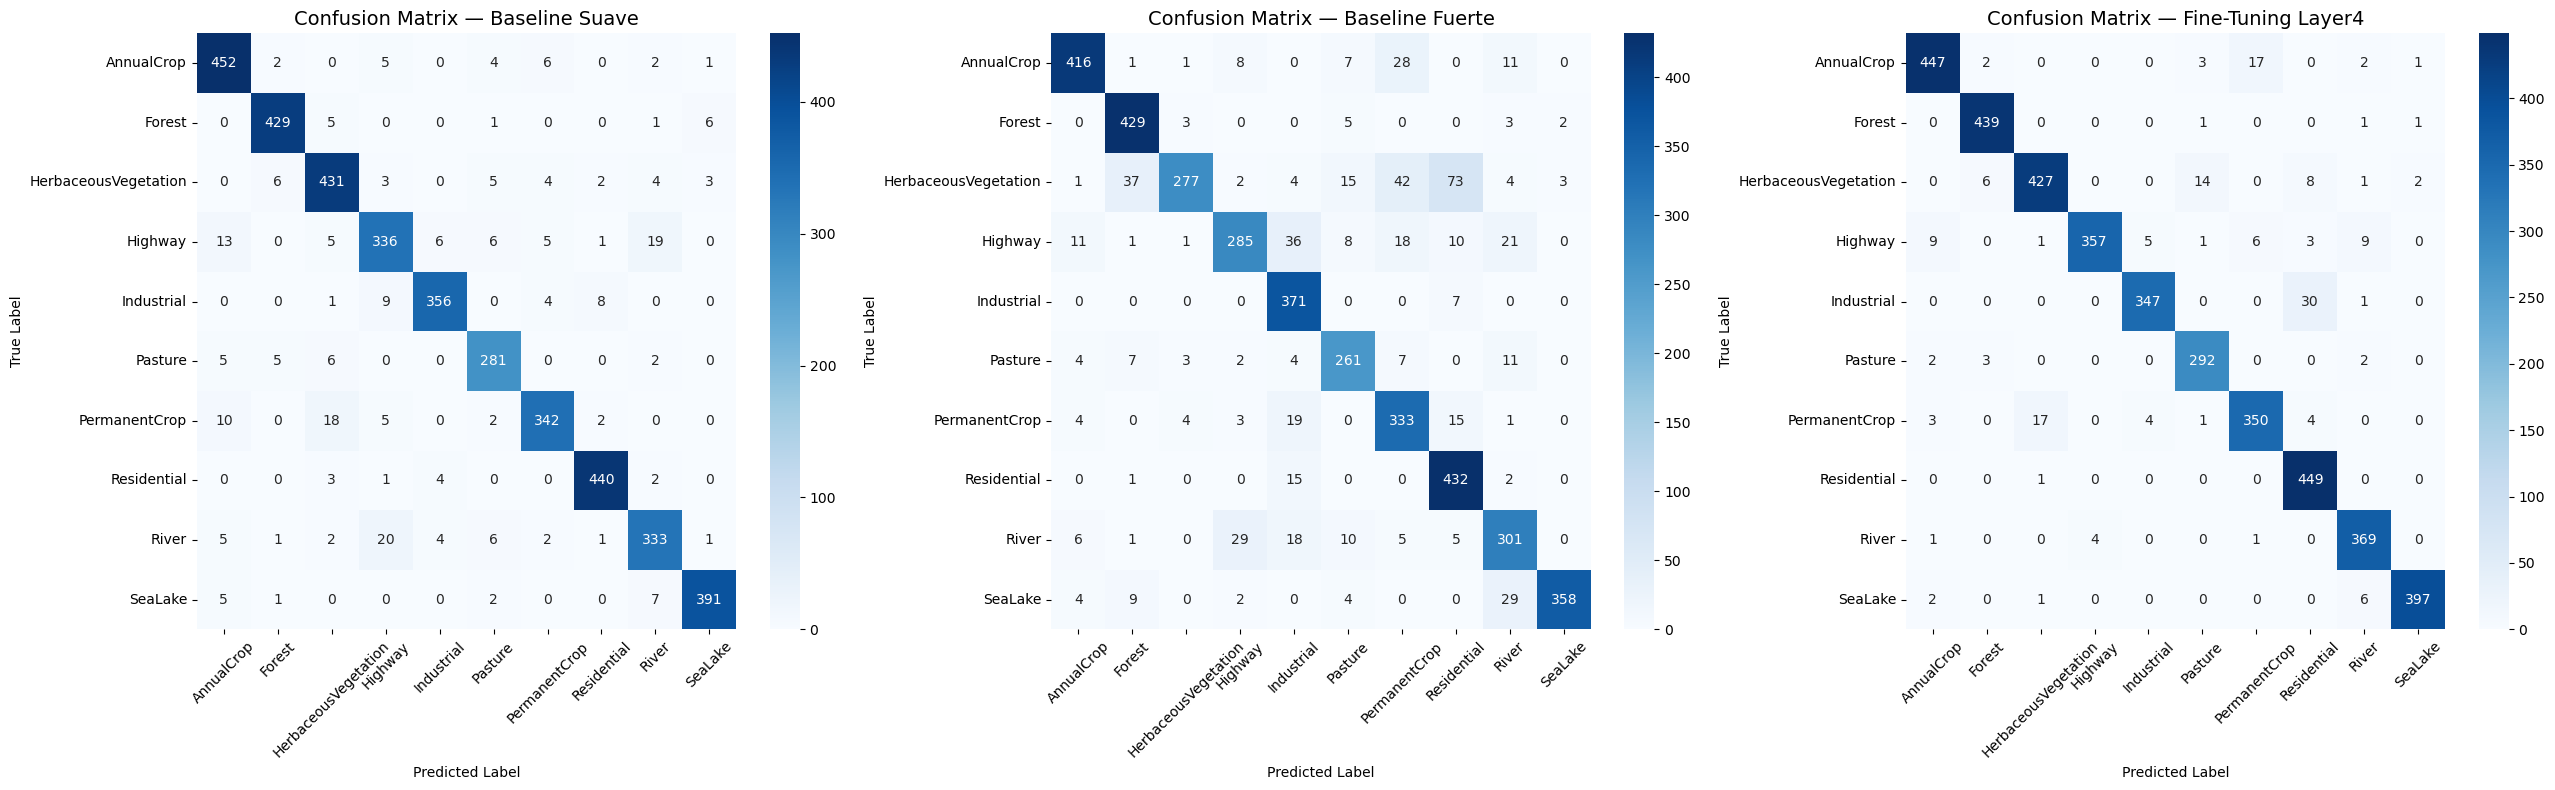

In [ ]:


# === Función auxiliar para graficar una matriz de confusión ===
def plot_confusion(ax, y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
        cbar=True
    )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# === Crear figura en layout 1x3 ===
fig, axes = plt.subplots(1, 3, figsize=(26, 8))

plot_confusion(
    axes[0],
    bl_soft_y_true,
    bl_soft_y_pred,
    "Confusion Matrix — Baseline Suave",
    class_names
)

plot_confusion(
    axes[1],
    bl_strong_true,
    bl_strong_pred,
    "Confusion Matrix — Baseline Fuerte",
    class_names
)

plot_confusion(
    axes[2],
    ft_y_true,
    ft_y_pred,
    "Confusion Matrix — Fine-Tuning Layer4",
    class_names
)

plt.tight_layout()
plt.show()


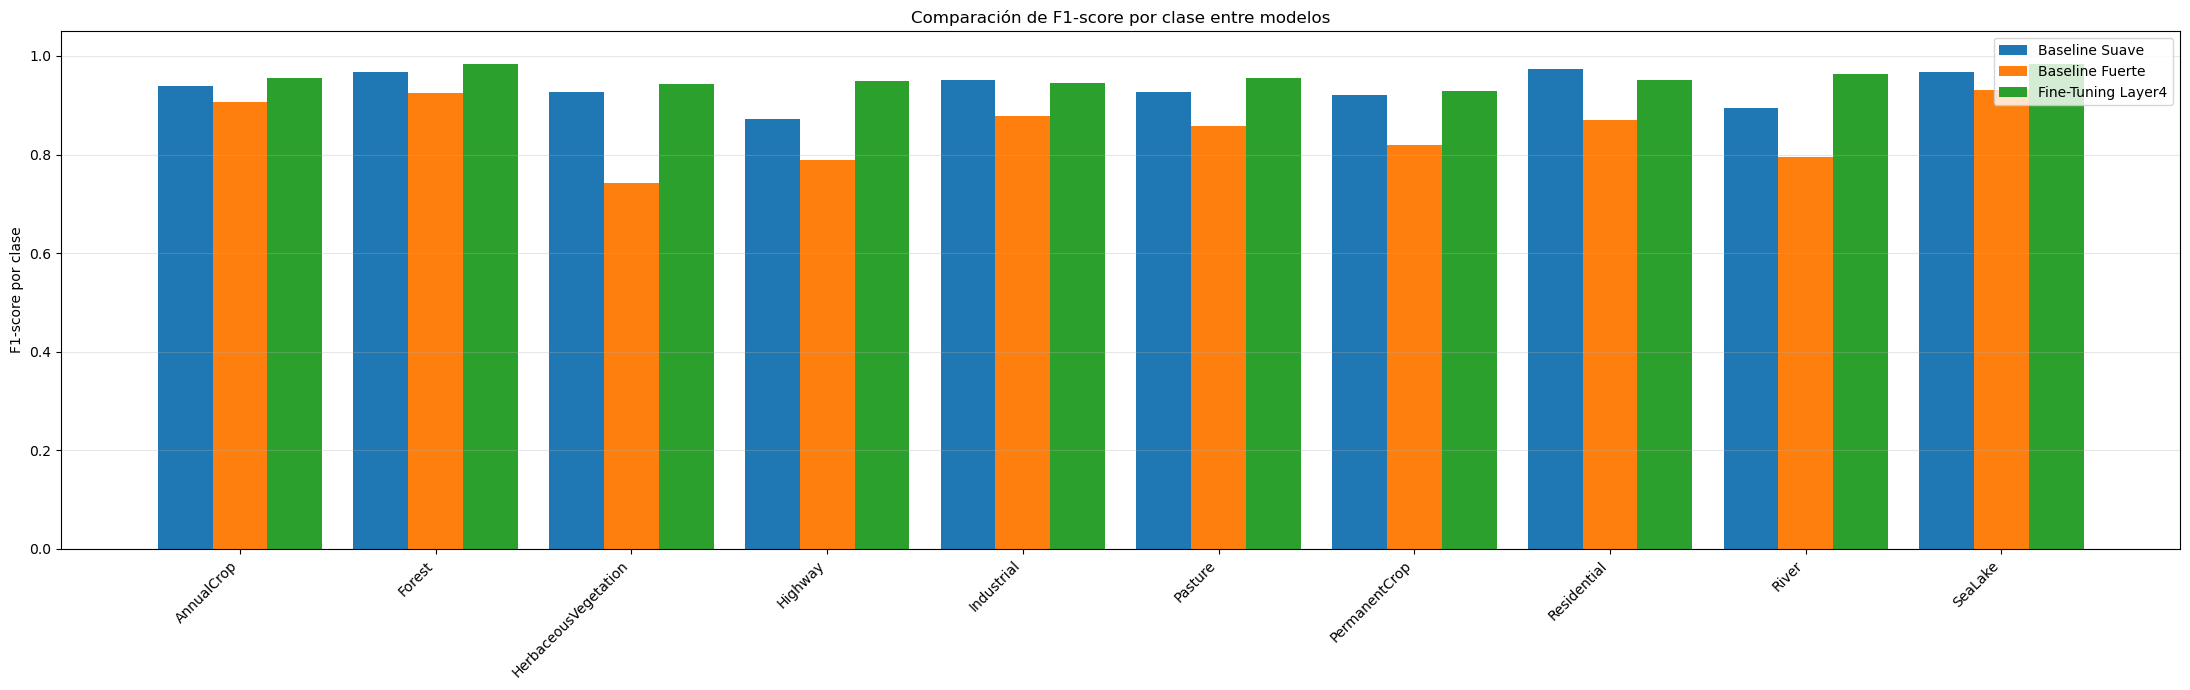

In [ ]:


# === Calcular F1 por clase para cada modelo ===
f1_soft   = f1_score(bl_soft_y_true,   bl_soft_y_pred,   average=None)
f1_strong = f1_score(bl_strong_true,   bl_strong_pred,   average=None)
f1_ft     = f1_score(ft_y_true,        ft_y_pred,        average=None)

# === Preparar gráfico ===
x = np.arange(len(class_names))
width = 0.28  # ancho de cada barra

plt.figure(figsize=(22, 7))

plt.bar(x - width, f1_soft,   width, label="Baseline Suave")
plt.bar(x,          f1_strong, width, label="Baseline Fuerte")
plt.bar(x + width,  f1_ft,     width, label="Fine-Tuning Layer4")

# === Configuración del gráfico ===
plt.xticks(x, class_names, rotation=45, ha='right')
plt.ylabel("F1-score por clase")
plt.title("Comparación de F1-score por clase entre modelos")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:


# ================================================
# Función auxiliar: genera tabla de F1 ordenada
# ================================================
def generate_f1_table(y_true, y_pred, class_names):
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=range(len(class_names))
    )

    order = np.argsort(f1)[::-1]

    table_html = "<pre style='font-family:monospace; font-size:13px;'>"
    table_html += f"{'Clase':<25} {'F1':<8} {'Soporte'}\n"
    table_html += "-"*45 + "\n"

    for idx in order:
        table_html += f"{class_names[idx]:<25} {f1[idx]:<8.3f} {support[idx]}\n"

    table_html += "</pre>"
    return table_html


# ==========================================
# Generar fila 1: Tablas de F1 ordenadas
# ==========================================
f1_row_html = f"""
<div style="display:flex; gap:20px; justify-content:space-between;">

    <div style="flex:1;">
        <h4 style='text-align:center;'>Baseline Suave — F1</h4>
        {generate_f1_table(bl_soft_y_true, bl_soft_y_pred, class_names)}
    </div>

    <div style="flex:1;">
        <h4 style='text-align:center;'>Baseline Fuerte — F1</h4>
        {generate_f1_table(bl_strong_true, bl_strong_pred, class_names)}
    </div>

    <div style="flex:1;">
        <h4 style='text-align:center;'>Fine-Tuning Layer4 — F1</h4>
        {generate_f1_table(ft_y_true, ft_y_pred, class_names)}
    </div>

</div>
"""

# =====================================================
# Generar fila 2: Classification Reports
# =====================================================
report_soft   = classification_report(bl_soft_y_true,   bl_soft_y_pred,   target_names=class_names)
report_strong = classification_report(bl_strong_true,   bl_strong_pred,   target_names=class_names)
report_ft     = classification_report(ft_y_true,        ft_y_pred,        target_names=class_names)

report_row_html = f"""
<div style="display:flex; gap:20px; justify-content:space-between; margin-top:35px;">

    <div style="flex:1;">
        <h4 style='text-align:center;'>Baseline Suave — Reporte</h4>
        <pre style='font-family:monospace; font-size:13px;'>{report_soft}</pre>
    </div>

    <div style="flex:1;">
        <h4 style='text-align:center;'>Baseline Fuerte — Reporte</h4>
        <pre style='font-family:monospace; font-size:13px;'>{report_strong}</pre>
    </div>

    <div style="flex:1;">
        <h4 style='text-align:center;'>Fine-Tuning Layer4 — Reporte</h4>
        <pre style='font-family:monospace; font-size:13px;'>{report_ft}</pre>
    </div>

</div>
"""

# Mostrar todo
display(HTML(f1_row_html + "<br><br>" + report_row_html))


#### Adición de perturbaciones y pruebas de Stress

In [202]:
import numpy as np
from PIL import Image, ImageOps, ImageFilter

# ============================================================
# Funciones de perturbación para stress testing
# Estas funciones operan sobre imágenes PIL, antes de ToTensor.
# ============================================================

def truncate_bits(img, bits=4):
    """
    Reduce la profundidad de bits de una imagen (posterización).
    bits=8 → imagen normal, bits=4 → 16 niveles, bits=2 → 4 niveles.
    """
    img_arr = np.array(img).astype(np.uint8)
    shift = 8 - bits
    img_arr = (img_arr >> shift) << shift
    return Image.fromarray(img_arr)

def downscale(img, factor=0.5):
    """
    Reduce la resolución de la imagen y la vuelve a escalar al tamaño original.
    factor < 1 → pérdida de detalle.
    """
    w, h = img.size
    new_w, new_h = int(w * factor), int(h * factor)
    img_small = img.resize((new_w, new_h), Image.BICUBIC)
    img_back = img_small.resize((w, h), Image.BICUBIC)
    return img_back

def scale_brightness(img, k=0.5):
    """
    Ajusta el brillo multiplicando por un factor k.
    k < 1 oscurece, k > 1 aclara.
    """
    img_arr = np.array(img).astype(np.float32)
    img_arr = np.clip(img_arr * k, 0, 255).astype(np.uint8)
    return Image.fromarray(img_arr)

def apply_blur(img, radius=2):
    """
    Aplica blur gaussiano para simular sensores de baja nitidez.
    """
    return img.filter(ImageFilter.GaussianBlur(radius))


In [203]:
transform_bits4 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: truncate_bits(img, bits=4)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

transform_downscale_025 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: downscale(img, factor=0.25)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

transform_brightness_02 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: scale_brightness(img, k=0.2)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

transform_blur_3 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: apply_blur(img, radius=3)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [204]:
# ============================================================
# Función auxiliar para crear perturbation loaders con paths
# ============================================================

def make_perturbation_loader(transform):
    dataset = ImageFolderWithPaths(DATASET_DIR, transform=transform)
    dataset = Subset(dataset, test_dataset.indices)  # mismos índices del test limpio
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)


In [205]:
# ============================================================
# LOADERS DE PERTURBACIONES (con paths)
# ============================================================

test_loader_bits4      = make_perturbation_loader(transform_bits4)
test_loader_down_025   = make_perturbation_loader(transform_downscale_025)
test_loader_bright_02  = make_perturbation_loader(transform_brightness_02)
test_loader_blur_3     = make_perturbation_loader(transform_blur_3)

print("📷 Loaders de perturbaciones creados correctamente.")


📷 Loaders de perturbaciones creados correctamente.


In [206]:
# ============================================================
# EVALUACIÓN DE ROBUSTEZ EN TODAS LAS PERTURBACIONES
# ============================================================

results = []

tests = [
    ("clean",      test_loader_paths),   # test limpio con paths
    ("bits4",      test_loader_bits4),
    ("down_025",   test_loader_down_025),
    ("bright_02",  test_loader_bright_02),
    ("blur_3",     test_loader_blur_3),
]

# 1) Baseline suave
for name, loader in tests:
    _, acc, _, _, _, _ = evaluate_model(model, loader, criterion, device)
    results.append(("baseline_soft", name, acc))

# 2) Baseline fuerte
for name, loader in tests:
    _, acc, _, _, _, _ = evaluate_model(model_strong, loader, criterion, device)
    results.append(("baseline_strong", name, acc))

# 3) Fine-tuning (layer4 descongelada)
for name, loader in tests:
    _, acc, _, _, _, _ = evaluate_model(resnet50_finetunning, loader, criterion, device)
    results.append(("finetuned", name, acc))

print("✔ Evaluación de robustez completada.")


✔ Evaluación de robustez completada.


In [ ]:


df_results = pd.DataFrame(results, columns=["modelo", "test", "accuracy"])
df_results


modelo       test  accuracy
0     baseline_soft      clean  0.936049
1     baseline_soft      bits4  0.368395
2     baseline_soft   down_025  0.800741
3     baseline_soft  bright_02  0.113086
4     baseline_soft     blur_3  0.466914
5   baseline_strong      clean  0.855062
6   baseline_strong      bits4  0.582963
7   baseline_strong   down_025  0.869877
8   baseline_strong  bright_02  0.535309
9   baseline_strong     blur_3  0.791358
10        finetuned      clean  0.956543
11        finetuned      bits4  0.761728
12        finetuned   down_025  0.955802
13        finetuned  bright_02  0.834568
14        finetuned     blur_3  0.868889

##### Visualizaciones graficas de los modelos ante stress

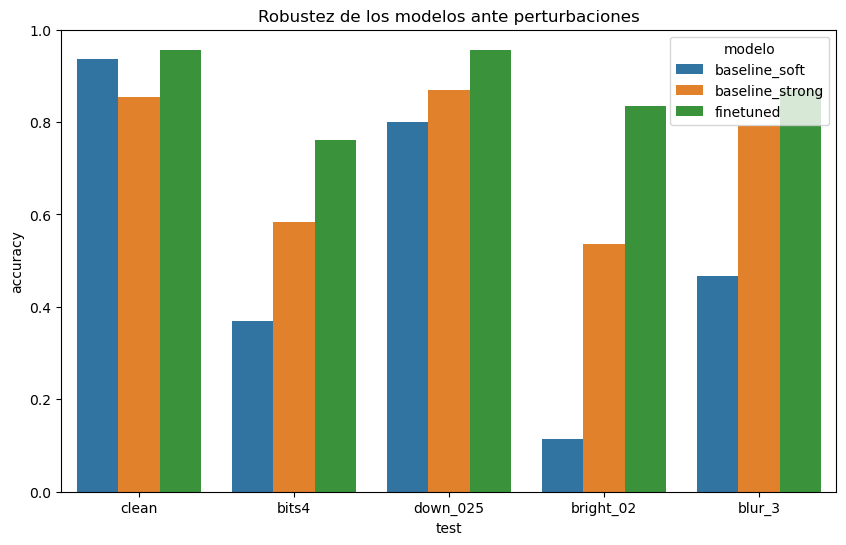

In [ ]:

plt.figure(figsize=(10,6))
sns.barplot(data=df_results, x="test", y="accuracy", hue="modelo")
plt.title("Robustez de los modelos ante perturbaciones")
plt.ylim(0,1)
plt.show()


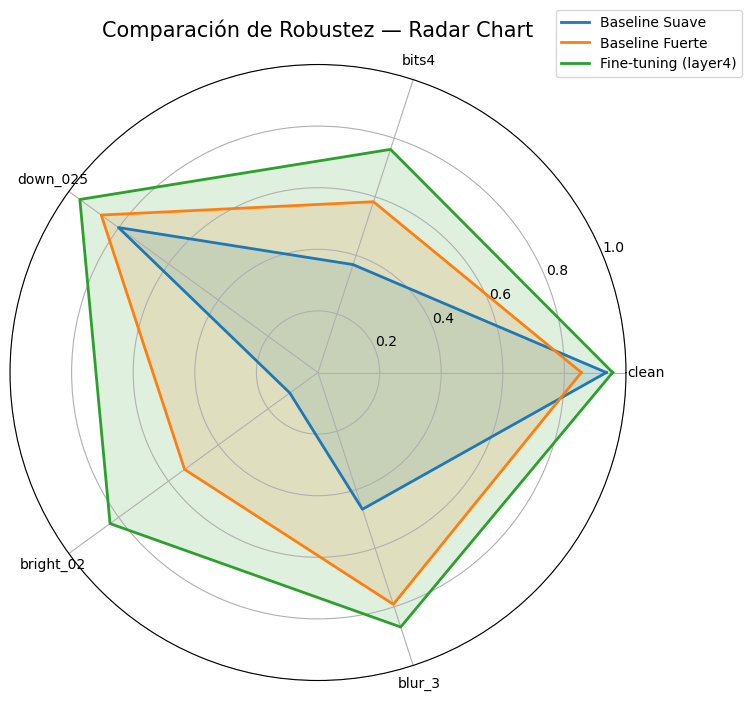

In [ ]:


# Orden fijo de perturbaciones
perturbaciones = ["clean", "bits4", "down_025", "bright_02", "blur_3"]

# Extraer accuracies ordenadas
def get_accs(model_name):
    row = df_results[df_results["modelo"] == model_name]
    row = row.set_index("test").loc[perturbaciones]["accuracy"].values
    return row.tolist()

acc_soft   = get_accs("baseline_soft")
acc_strong = get_accs("baseline_strong")
acc_ft     = get_accs("finetuned")

# Cerrar el polígono agregando el primer valor al final
acc_soft.append(acc_soft[0])
acc_strong.append(acc_strong[0])
acc_ft.append(acc_ft[0])

# Ángulos del radar
N = len(perturbaciones)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles.append(angles[0])  # cerrar polígono

# Crear figura
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# ============ Dibujar cada modelo ============
ax.plot(angles, acc_soft,   linewidth=2, label="Baseline Suave")
ax.fill(angles, acc_soft, alpha=0.15)

ax.plot(angles, acc_strong, linewidth=2, label="Baseline Fuerte")
ax.fill(angles, acc_strong, alpha=0.15)

ax.plot(angles, acc_ft, linewidth=2, label="Fine-tuning (layer4)")
ax.fill(angles, acc_ft, alpha=0.15)

# ============ Personalización ============
ax.set_xticks(angles[:-1])
ax.set_xticklabels(perturbaciones)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])
ax.set_ylim(0, 1)

plt.title("Comparación de Robustez — Radar Chart", size=15, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()


##### Ejemplos de imagenes clasificadas correcta e incorrectamente del modelo finetunned

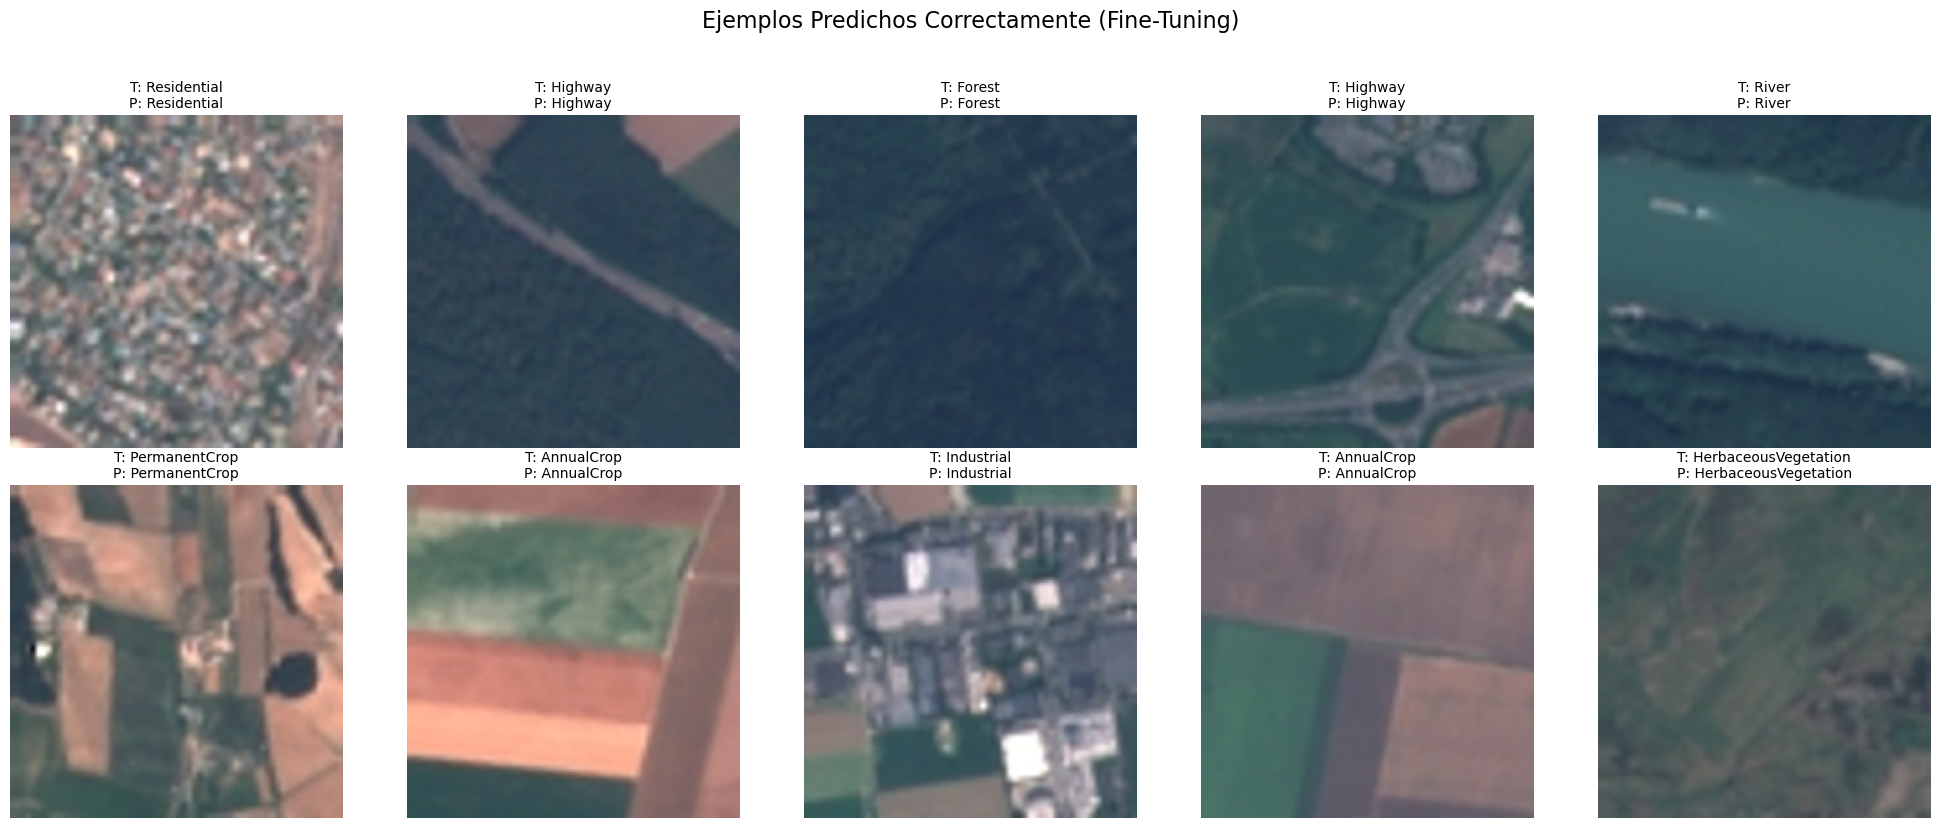

In [210]:
# ============================================
# 10 imágenes correctamente clasificadas 
# ============================================

VIS_SIZE = (224, 224)  # mismo tamaño que la celda original

# Seleccionar hasta 10 índices correctos (aleatorios)
correct_idx = [i for i in range(len(ft_y_true)) if ft_y_true[i] == ft_y_pred[i]]
sample_correct = random.sample(correct_idx, min(10, len(correct_idx)))

plt.figure(figsize=(20, 8))  # figura amplia para 2×5

for i, idx in enumerate(sample_correct):
    img = Image.open(ft_paths[idx]).resize(VIS_SIZE)  
    true_label = class_names[ft_y_true[idx]]
    pred_label = class_names[ft_y_pred[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=10)

plt.suptitle("Ejemplos Predichos Correctamente (Fine-Tuning)", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()


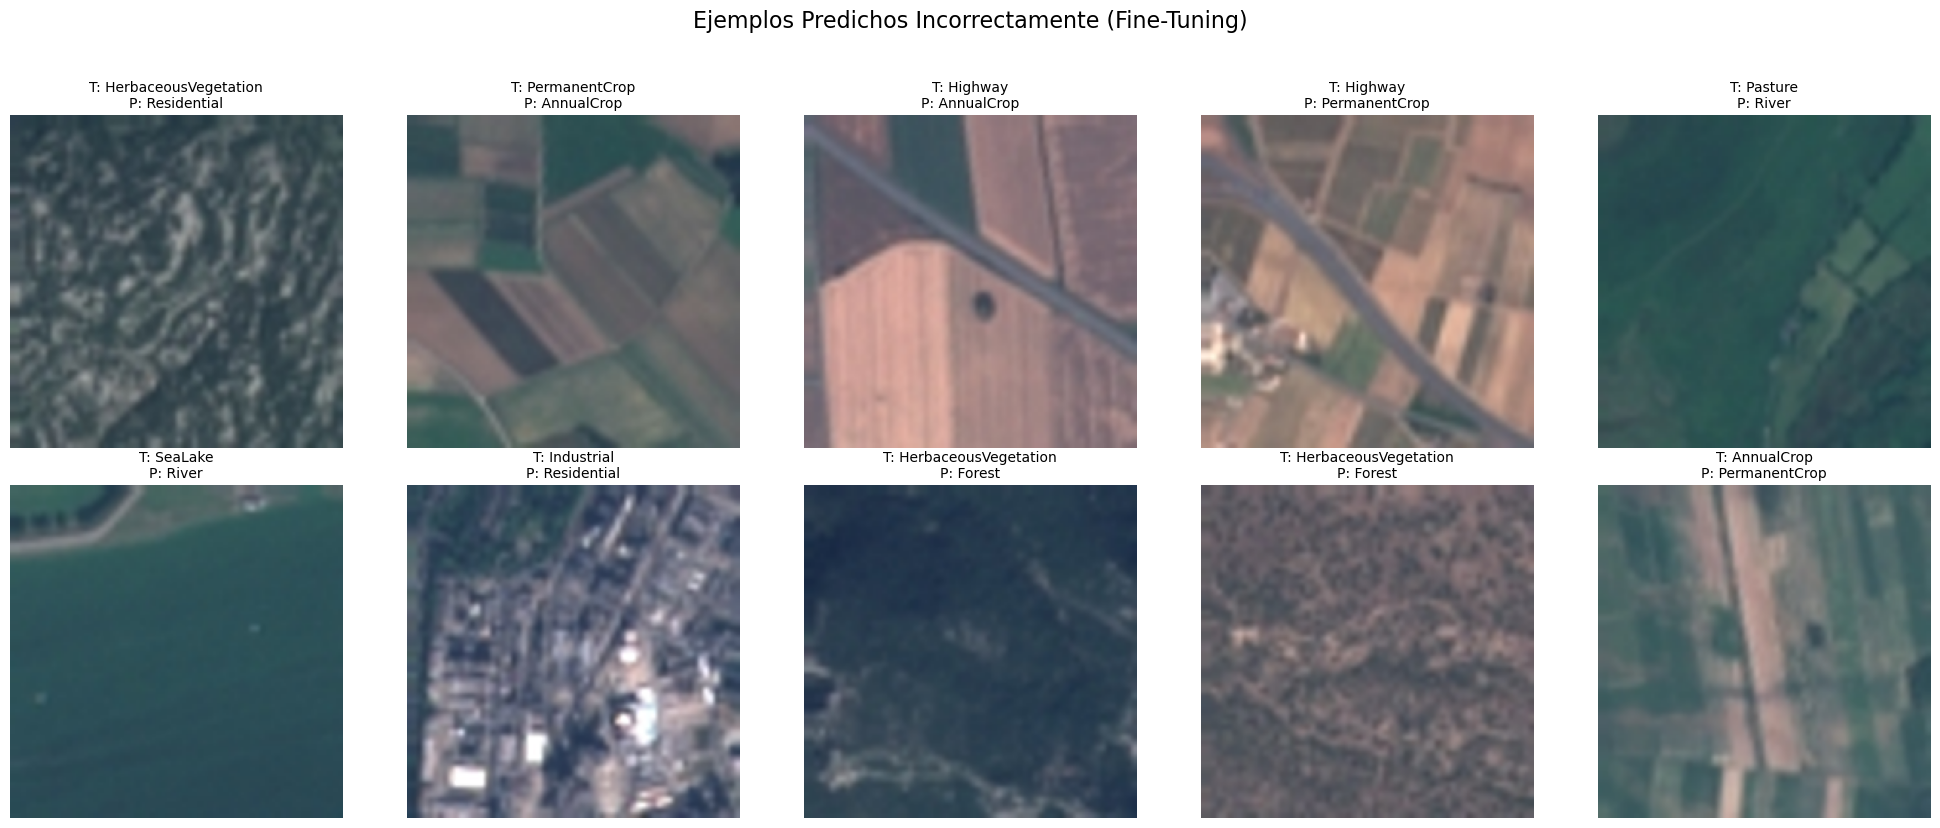

In [211]:
# ============================================
# 10 imágenes incorrectamente clasificadas 
# ============================================

VIS_SIZE = (224, 224)

# Seleccionar hasta 10 índices incorrectos (aleatorios)
incorrect_idx = [i for i in range(len(ft_y_true)) if ft_y_true[i] != ft_y_pred[i]]
sample_incorrect = random.sample(incorrect_idx, min(10, len(incorrect_idx)))

plt.figure(figsize=(20, 8))

for i, idx in enumerate(sample_incorrect):
    img = Image.open(ft_paths[idx]).resize(VIS_SIZE)
    true_label = class_names[ft_y_true[idx]]
    pred_label = class_names[ft_y_pred[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=10)

plt.suptitle("Ejemplos Predichos Incorrectamente (Fine-Tuning)", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()
